#Chargez les données dans des fichiers excel pour les visualiser

In [ ]:
import numpy as np
import pandas as pd

# Fonction pour charger et afficher le contenu d'un fichier npy
def load_and_display_npy(file_path):
    data = np.load(file_path, allow_pickle=True)
    print(f"Content of {file_path}:")
    print(data)
    print("\n")

# Liste des fichiers npy
npy_files = ["ratings_train.npy", "ratings_test.npy", "namesngenre.npy", "list_index_wanted.npy"]

# Charger et afficher chaque fichier npy
for npy_file in npy_files:
    load_and_display_npy(npy_file)

# Fonction pour charger un fichier npy et l'enregistrer en tant que fichier Excel
def npy_to_excel(npy_file):
    # Charger le fichier npy
    data = np.load(npy_file, allow_pickle=True)

    # Convertir les données en DataFrame
    df = pd.DataFrame(data)

    # Enregistrer le DataFrame dans un fichier Excel avec le même nom
    excel_file = npy_file.replace('.npy', '.xlsx')
    df.to_excel(excel_file, index=False)
    print(f"Saved {npy_file} to {excel_file}")

# Convertir chaque fichier npy en fichier Excel
for npy_file in npy_files:
    npy_to_excel(npy_file)

#I. Méthode MF (Matrix Factorization) de Cornac

##Étape 1: Installation de Cornac

In [2]:
!pip install -U cornac


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.8 MB/s eta 0:00:00


##Étape 2: Préparation des Données

###Étape 2.1: Préparation des Données pour Intégrer les Genres


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Charger les genres des films
namesngenre = pd.read_excel('namesngenre.xlsx', header=None)
namesngenre.columns = ['film', 'genres']
namesngenre['genres'] = namesngenre['genres'].astype(str).apply(lambda x: x.split('|'))

# Encoder les genres avec MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(namesngenre['genres'])


###Étape 2.2: Préparation des Données pour définir les triplets (user, film, rating)

In [5]:
from cornac.data import Dataset, GraphModality

# Charger les données
ratings_train = pd.read_excel('ratings_train.xlsx', header=None).values

# Transformer les genres en triplets
genre_triplets = []
for item_id, genres in enumerate(genres_encoded):
    for genre_id, is_present in enumerate(genres):
        if is_present:
            genre_triplets.append((item_id, genre_id, 1))  # 1 indique que le genre est présent pour cet item

# Créer un objet GraphModality pour les attributs des items (genres des films)
item_graph = GraphModality(data=genre_triplets, form='binary')

In [6]:
import numpy as np
import math

# Charger les données d'entraînement et de test
train_data = pd.read_excel('ratings_train.xlsx', header=None)
test_data = pd.read_excel('ratings_test.xlsx')

# Préparer les triplets d'entraînement (user, item, rating) en tenant compte des NaN
train_triplets = []
num_users_train, num_items_train = train_data.shape
for user in range(num_users_train):
    for item in range(num_items_train):
        rating = train_data.iloc[user, item]
        if not math.isnan(rating):
            train_triplets.append((user, item, rating))

# Préparer les triplets de test (user, item, rating) en tenant compte des NaN
test_triplets = []
num_users_test, num_items_test = test_data.shape
for user in range(num_users_test):
    for item in range(num_items_test):
        rating = test_data.iloc[user, item]
        if not math.isnan(rating):
            test_triplets.append((user, item, rating))

##Étape 3: Utiliser Cornac pour utiliser MF (Matrix Factorization) à l'entrainement

In [7]:
from cornac.eval_methods import BaseMethod

# Charger les données d'entraînement et de test avec Cornac Reader
train_data_cornac = Dataset.from_uir(train_triplets)
test_data_cornac = Dataset.from_uir(test_triplets)

# Définir une méthode d'évaluation personnalisée avec les ensembles de train et de test et les attributs item_graph
eval_method = BaseMethod.from_splits(
    train_data=train_triplets,
    test_data=test_triplets,
    rating_threshold=1.0,
    exclude_unknowns=True,
    verbose=True,
    item_graph=item_graph  # Ajout des attributs contextuels pour enrichir le modèle
)

from cornac.models import MF
from cornac.metrics import RMSE, MAE
import cornac

# Définir le modèle MF
mf_model = MF(k=10, max_iter=100, learning_rate=0.01, lambda_reg=0.02, verbose=True)

# Entraîner le modèle et évaluer ses performances sur l'ensemble de test en utilisant item_graph
cornac.Experiment(
    eval_method=eval_method,
    models=[mf_model],
    metrics=[RMSE(), MAE()]
).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 610
Number of items = 4980
Number of ratings = 31598
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 610
Number of items = 4980
Number of ratings = 31598
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 610
Total items = 4980

[MF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[MF] Evaluation started!


Rating:   0%|          | 0/31598 [00:00<?, ?it/s]


TEST:
...
   |    MAE |   RMSE | Train (s) | Test (s)
-- + ------ + ------ + --------- + --------
MF | 0.7674 | 0.9596 |    1.3680 |   1.9222



##Étape 4: Prédire les Notes

In [11]:
from scipy.sparse import lil_matrix

# Charger le fichier list_index_wanted pour obtenir les indices des utilisateurs et des films
list_index_wanted = pd.read_excel('list_index_wanted.xlsx', header=None)
list_index_wanted.columns = ['user', 'item']

# Préparer les indices des utilisateurs et items pour lesquels il faut prédire
indices_to_predict = list_index_wanted.values

# Créer une matrice creuse pour stocker les valeurs prédites
num_users = train_data_cornac.num_users
num_items = train_data_cornac.num_items
# Utilisation de lil_matrix (List of Lists), qui est un format efficace pour modifier la matrice (ajouter des valeurs prédictives)
sparse_matrix = lil_matrix((num_users, num_items))

# Effectuer des prédictions pour chaque couple (utilisateur, item) donné
for user, item in indices_to_predict:
    # Vérifier si l'utilisateur et l'item existent dans les données d'entraînement
    if user < num_users and item < num_items:
        # Prédire la note pour le couple (utilisateur, item)
        predicted_rating = mf_model.score(user, item)
        # Ajouter la prédiction dans la matrice creuse
        sparse_matrix[user, item] = predicted_rating

# Convertir la matrice creuse au format dense
dense_matrix = sparse_matrix.toarray()

# Sauvegarder la matrice dense au format .npy
np.save('MF_predicted_ratings_matrix.npy', dense_matrix)

print("Prédictions terminées et matrice sauvegardée au format .npy avec succès.")

Prédictions terminées et matrice sauvegardée au format .npy avec succès.


#II. Méthode ALS

###Définir les les fonctions constituant le modéle

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
ratings_train = np.load('ratings_train.npy')
ratings_test = np.load('ratings_test.npy')

# Paramètres du modèle ALS
lambda_reg = 5
num_latent = 30
num_iterations = 100

# Listes pour suivre les métriques au cours des itérations
train_rmse_set = []
test_rmse_set = []
train_mae_set = []
test_mae_set = []

# Fonction pour évaluer les erreurs RMSE et MAE
def RMSE_MAE(R, predictions):
    mask = ~np.isnan(R)
    rmse = np.sqrt(np.mean((R[mask] - predictions[mask])**2))
    mae = np.mean(np.abs(R[mask] - predictions[mask]))
    return rmse, mae

# Mettre à jour la matrice U (fixer V et résoudre U)
def update_U(U, V, ratings_train, lambda_reg):
    num_users = ratings_train.shape[0]
    num_latent = U.shape[1]
    for user_index in range(num_users):
        # Filtrer les items évalués par l'utilisateur actuel
        indices_items_notes = ~np.isnan(ratings_train[user_index, :])
        V_evaluated = V[indices_items_notes, :]
        ratings_evaluated_by_user = ratings_train[user_index, indices_items_notes]

        if ratings_evaluated_by_user.size > 0:
            A = np.dot(V_evaluated.T, V_evaluated) + lambda_reg * np.eye(num_latent)
            b = np.dot(V_evaluated.T, ratings_evaluated_by_user)
            U[user_index, :] = np.linalg.solve(A, b)
    return U

# Mettre à jour la matrice V (fixer U et résoudre V)
def update_V(U, V, ratings_train, lambda_reg):
    num_items = ratings_train.shape[1]
    num_latent = V.shape[1]
    for item_index in range(num_items):
        # Filtrer les utilisateurs ayant évalué l'item actuel
        indices_users_notes = ~np.isnan(ratings_train[:, item_index])
        U_evaluated = U[indices_users_notes, :]
        ratings_for_item = ratings_train[indices_users_notes, item_index]

        if ratings_for_item.size > 0:
            C = np.dot(U_evaluated.T, U_evaluated) + lambda_reg * np.eye(num_latent)
            d = np.dot(U_evaluated.T, ratings_for_item)
            V[item_index, :] = np.linalg.solve(C, d)
    return V

# Entraîner le modèle ALS
def train_ALS(ratings_train, ratings_test, num_latent, lambda_reg, num_iterations):
    num_users, num_items = ratings_train.shape

    U = np.random.rand(num_users, num_latent)
    V = np.random.rand(num_items, num_latent)

    # Boucle d'entraînement ALS
    for iteration in range(num_iterations):
        U = update_U(U, V, ratings_train, lambda_reg)
        V = update_V(U, V, ratings_train, lambda_reg)

        # Prédire les notes
        predictions = np.dot(U, V.T)

        # Calculer les métriques pour l'ensemble d'entraînement et de test
        rmse_train, mae_train = RMSE_MAE(ratings_train, predictions)
        rmse_test, mae_test = RMSE_MAE(ratings_test, predictions)

        # Stocker les métriques pour les graphes
        train_rmse_set.append(rmse_train)
        test_rmse_set.append(rmse_test)
        train_mae_set.append(mae_train)
        test_mae_set.append(mae_test)

    return U, V, train_rmse_set, test_rmse_set, train_mae_set, test_mae_set


###Entrainer le modéle

In [10]:
# Entraîner le modèle ALS
U, V, train_rmse_set, test_rmse_set, train_mae_set, test_mae_set = train_ALS(ratings_train, ratings_test, num_latent, lambda_reg, num_iterations)
# Calculer les prédictions pour chaque utilisateur et item
predictions = np.dot(U, V.T)

# Limiter les valeurs prédites dans l'intervalle [0.5, 5]
clipped_predictions = np.clip(predictions, a_min=0.5, a_max=5)

# Calculer les métriques pour l'ensemble d'entraînement et de test
train_rmse, train_mae = RMSE_MAE(ratings_train, clipped_predictions)
test_rmse, test_mae = RMSE_MAE(ratings_test, clipped_predictions)

# Afficher les errors finales
print(f"RMSE du Train: {train_rmse:.4f}")
print(f"RMSE du Test: {test_rmse:.4f}")
print(f"MAE du Train: {train_mae:.4f}")
print(f"MAE du Test: {test_mae:.4f}")

RMSE du Train: 0.5257
RMSE du Test: 1.1649
MAE du Train: 0.3760
MAE du Test: 0.9008


###Afficher les variations du RMSE & MAE au fil de l'entrainement (évolution)

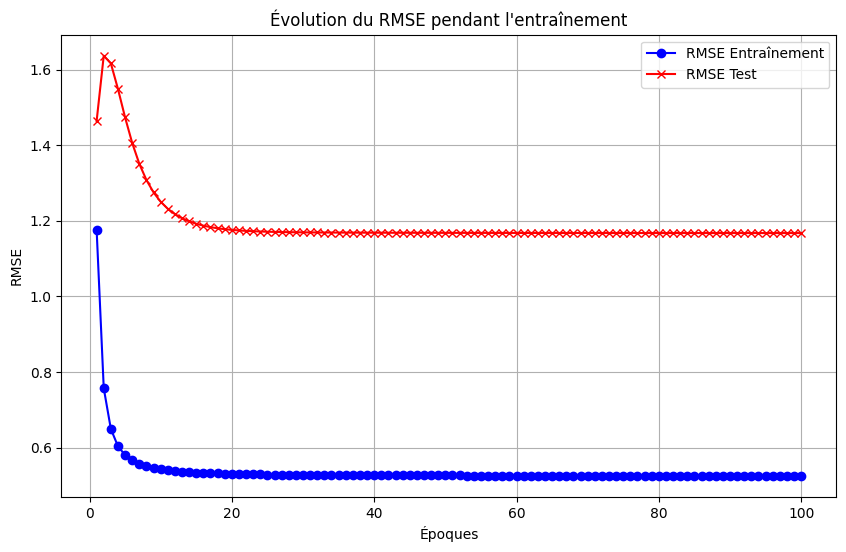

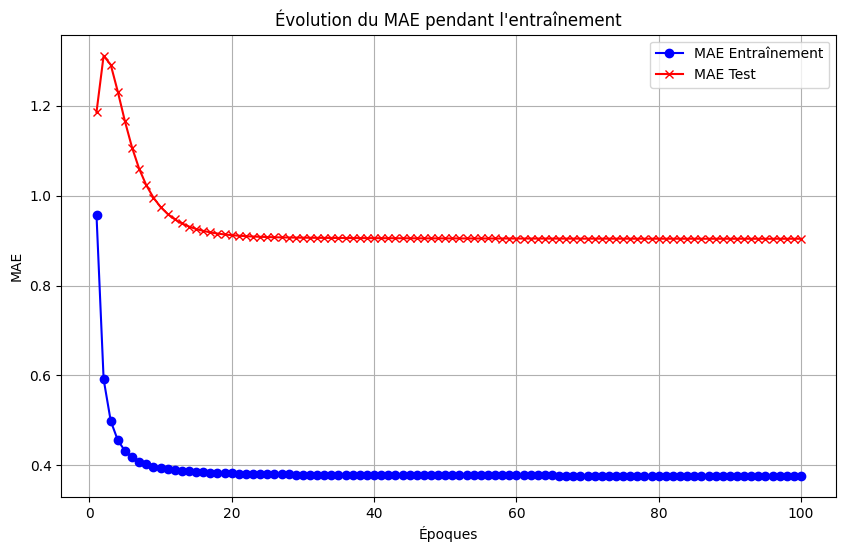

In [7]:
# Tracer les courbes de RMSE et MAE pendant l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), train_rmse_set, label="RMSE Entraînement", color='b', linestyle='-', marker='o')
plt.plot(range(1, num_iterations + 1), test_rmse_set, label="RMSE Test", color='r', linestyle='-', marker='x')
plt.title("Évolution du RMSE pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), train_mae_set, label="MAE Entraînement", color='b', linestyle='-', marker='o')
plt.plot(range(1, num_iterations + 1), test_mae_set, label="MAE Test", color='r', linestyle='-', marker='x')
plt.title("Évolution du MAE pendant l'entraînement")
plt.xlabel("Époques")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Effectuer la recherche sur grille des hyperparamètres
def grid_search_ALS(ratings_train, ratings_test, lambda_reg_list, num_latent_list, num_iterations_list):
    results = []

    # Boucles imbriquées pour toutes les combinaisons d'hyperparamètres
    for lambda_reg in lambda_reg_list:
        for num_latent in num_latent_list:
            for num_iterations in num_iterations_list:
                print(f"Entraînement avec lambda_reg={lambda_reg}, num_latent={num_latent}, num_iterations={num_iterations}")

                # Entraîner le modèle ALS
                U, V, train_rmse_set, test_rmse_set, train_mae_set, test_mae_set = train_ALS(
                    ratings_train, ratings_test, num_latent, lambda_reg, num_iterations)

                # Stocker les métriques finales
                final_rmse_train = train_rmse_set[-1]
                final_rmse_test = test_rmse_set[-1]
                final_mae_train = train_mae_set[-1]
                final_mae_test = test_mae_set[-1]

                results.append({
                    'lambda_reg': lambda_reg,
                    'num_latent': num_latent,
                    'num_iterations': num_iterations,
                    'final_rmse_train': final_rmse_train,
                    'final_rmse_test': final_rmse_test,
                    'final_mae_train': final_mae_train,
                    'final_mae_test': final_mae_test
                })

    # Convertir les résultats en DataFrame pour une visualisation facile
    results_df = pd.DataFrame(results)
    return results_df

# Définir les hyperparamètres à tester
lambda_reg_list = [1, 3, 7, 10]
num_latent_list = [10, 15, 25, 30]
num_iterations_list = [100, 200]

# Effectuer la recherche sur grille des hyperparamètres
results_df = grid_search_ALS(ratings_train, ratings_test, lambda_reg_list, num_latent_list, num_iterations_list)

# Afficher les résultats dans un tableau
print(results_df)

# Identifier la meilleure combinaison d'hyperparamètres
best_row = results_df.loc[results_df['final_rmse_test'].idxmin()]
print("\nMeilleure combinaison d'hyperparamètres basée sur le RMSE de test :")
print(best_row)

Entraînement avec lambda_reg=1, num_latent=10, num_iterations=100
Entraînement avec lambda_reg=1, num_latent=10, num_iterations=200
Entraînement avec lambda_reg=1, num_latent=15, num_iterations=100
Entraînement avec lambda_reg=1, num_latent=15, num_iterations=200
Entraînement avec lambda_reg=1, num_latent=25, num_iterations=100
Entraînement avec lambda_reg=1, num_latent=25, num_iterations=200
Entraînement avec lambda_reg=1, num_latent=30, num_iterations=100
Entraînement avec lambda_reg=1, num_latent=30, num_iterations=200
Entraînement avec lambda_reg=3, num_latent=10, num_iterations=100
Entraînement avec lambda_reg=3, num_latent=10, num_iterations=200
Entraînement avec lambda_reg=3, num_latent=15, num_iterations=100
Entraînement avec lambda_reg=3, num_latent=15, num_iterations=200
Entraînement avec lambda_reg=3, num_latent=25, num_iterations=100
Entraînement avec lambda_reg=3, num_latent=25, num_iterations=200
Entraînement avec lambda_reg=3, num_latent=30, num_iterations=100
Entraîneme

KeyError: 'rmse_test'

####Meilleure combinaison d'hyper-paramètres

In [12]:
# Identifier la meilleure combinaison d'hyperparamètres
best_row = results_df.loc[results_df['final_rmse_test'].idxmin()]
print("\nMeilleure combinaison d'hyperparamètres basée sur le RMSE de test :")
print(best_row)


Meilleure combinaison d'hyperparamètres basée sur le RMSE de test :
lambda_reg            3.000000
num_latent           30.000000
num_iterations      100.000000
final_rmse_train      0.336627
final_rmse_test       1.169148
final_mae_train       0.235766
final_mae_test        0.907979
Name: 14, dtype: float64


##Prédire les ratings spécifiées

In [23]:
from scipy.sparse import lil_matrix

# Entraîner le modèle ALS avec la meilleure combinaison trouvée
num_latent = 30
lambda_reg = 3
num_iterations = 100
U, V, train_rmse_set, test_rmse_set, train_mae_set, test_mae_set = train_ALS(ratings_train, ratings_test, num_latent, lambda_reg, num_iterations)

# Charger les indices à prédire
list_index_wanted = np.load('list_index_wanted.npy')

# Calculer les prédictions pour chaque utilisateur et item
predictions = np.dot(U, V.T)

# Limiter les valeurs prédites dans l'intervalle [0.5, 5]
clipped_predictions = np.clip(predictions, a_min=0.5, a_max=5)

# Créer une matrice creuse pour stocker les valeurs prédites spécifiées dans `list_index_wanted`
num_users, num_items = ratings_train.shape
sparse_matrix = lil_matrix((num_users, num_items))

# Remplir la matrice creuse avec les prédictions pour les indices voulus
for user, item in list_index_wanted:
    if user < num_users and item < num_items:
        sparse_matrix[user, item] = clipped_predictions[user, item]

# Sauvegarder la matrice creuse au format .npy
np.save('ALS_predicted_ratings_matrix.npy', sparse_matrix)

print("Prédictions terminées et matrice creuse sauvegardée avec succès.")


Prédictions terminées et matrice creuse sauvegardée avec succès.


#III. ALS du package pyspark

###Charger les données et les transformer en format adéquat (triplets)

In [20]:
import numpy as np
import math
import pandas as pd

# Charger les données
ratings_train = pd.read_excel('ratings_train.xlsx', header=None).values
ratings_test = pd.read_excel('ratings_test.xlsx').values

# Transformer en triplets (user, item, rating) en tenant compte des NaN
train_triplets = []
num_users, num_items = ratings_train.shape
for user in range(num_users):
    for item in range(num_items):
        rating = ratings_train[user, item]  # Accéder directement à l'élément via NumPy
        if not math.isnan(rating):  # Vérifier si la valeur n'est pas NaN
            train_triplets.append((user, item, rating))

test_triplets = []
num_users, num_items = ratings_test.shape
for user in range(num_users):
    for item in range(num_items):
        rating = ratings_train[user, item]  # Accéder directement à l'élément via NumPy
        if not math.isnan(rating):  # Vérifier si la valeur n'est pas NaN
            test_triplets.append((user, item, rating))

# Charger les triplets
train_triplets = [(int(user), int(item), float(rating)) for user, item, rating in train_triplets]
test_triplets = [(int(user), int(item), float(rating)) for user, item, rating in test_triplets]


###Entrainer le modèle et évaluer le avec les données de test

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

# Créer une session Spark
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# Convertir les triplets d'entraînement et de test en DataFrames Spark
train_df = spark.createDataFrame(train_triplets, ["user", "item", "rating"])
test_df = spark.createDataFrame(test_triplets, ["user", "item", "rating"])

# Définir le modèle ALS
als = ALS(maxIter=10, regParam=0.1, userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop")

# Entraîner le modèle sur l'ensemble d'entraînement
als_model = als.fit(train_df)

# Faire des prédictions sur l'ensemble de test
predictions = als_model.transform(test_df)

# Calculer le RMSE sur les prédictions
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE sur l'ensemble de test : {rmse}")


RMSE sur l'ensemble de test : 0.423411183168181


###Prédire les ratings spécifiées sur list_ratings_wanted

In [22]:
from scipy.sparse import lil_matrix
from pyspark.sql import Row

# Charger le fichier `list_index_wanted.npy` contenant les indices (utilisateur, item) à prédire
list_index_wanted = np.load('list_index_wanted.npy')

# Préparer les données pour la prédiction
wanted_triplets = [Row(user=int(user), item=int(item)) for user, item in list_index_wanted]
wanted_df = spark.createDataFrame(wanted_triplets)

# Faire des prédictions pour les indices donnés dans `list_index_wanted`
predictions = als_model.transform(wanted_df)

# Convertir les prédictions en Pandas DataFrame
predictions_df = predictions.select("user", "item", "prediction").toPandas()

# Créer une matrice creuse pour stocker les prédictions
sparse_matrix = lil_matrix((num_users, num_items))

# Remplir la matrice creuse avec les prédictions
for _, row in predictions_df.iterrows():
    user = int(row['user'])
    item = int(row['item'])
    predicted_rating = float(row['prediction'])

    # Limiter la valeur prédite dans l'intervalle [0.5, 5]
    predicted_rating = np.clip(predicted_rating, a_min=0.5, a_max=5)

    # Ajouter la prédiction dans la matrice creuse
    sparse_matrix[user, item] = predicted_rating

# Sauvegarder la matrice creuse au format .npy
np.save('ALS_pyspark_predicted_ratings_matrix.npy', sparse_matrix)

print("Prédictions terminées et matrice creuse sauvegardée avec succès.")

# Arrêter la session Spark
spark.stop()

Prédictions terminées et matrice creuse sauvegardée avec succès.


#IIII. Descente de gradient

###Définir les fonctions constituant le modèle

In [14]:
# Charger les données
ratings_train = np.load('ratings_train.npy')
ratings_test = np.load('ratings_test.npy')

# Fonction de perte
def compute_loss(R, U, V, lambda_reg, mu_reg):
    prediction = np.dot(U, V.T)
    mask = ~np.isnan(R)
    error = R - prediction
    error[~mask] = 0  # Remplacer les NaN par des zéros après l'application du masque  # Remplacer les NaN par des zéros après l'application du masque
    loss = np.sum(error**2) + lambda_reg * np.sum(U**2) + mu_reg * np.sum(V**2)
    return loss

# Gradient pour U et V
def compute_gradient_U(R, U, V, mu_reg):
    prediction = np.dot(U, V.T)
    mask = ~np.isnan(R)
    error = R - prediction
    error[~mask] = 0  # Remplacer les NaN par des zéros après l'application du masque
    grad_U_latent = -2 * np.dot(error, V) + 2 * mu_reg * U
    return grad_U_latent

def compute_gradient_V(R, U, V, lambda_reg):
    # V_enriched = np.hstack((V, genres_encoded))
    prediction = np.dot(U, V.T)
    mask = ~np.isnan(R)
    error = R - prediction
    error[~mask] = 0  # Remplacer les NaN par des zéros après l'application du masque
    grad_V = -2 * np.dot(error.T, U) + 2 * lambda_reg * V
    return grad_V

# Retourne le RMSE et MAE
def RMSE_MAE(R, predictions):
    mask = ~np.isnan(R)
    rmse = np.sqrt(np.mean((R[mask] - predictions[mask])**2))
    mae = np.mean(np.abs(R[mask] - predictions[mask]))
    return rmse, mae

# Lists to track metrics for plotting
rmse_train_list = []
rmse_test_list = []
mae_train_list = []
mae_test_list = []

# Algorithme de descente de gradient modifié
def gradient_descent(R, T, latent_features, learning_rate, lambda_reg, mu_reg, num_iterations):
    num_users, num_items = R.shape
    U = np.random.rand(num_users, latent_features)
    V = np.random.rand(num_items, latent_features)

    for iteration in range(num_iterations):
        grad_U_latent = compute_gradient_U(R, U, V, mu_reg)
        grad_V_latent = compute_gradient_V(R, U, V, lambda_reg)

        predictions = np.dot(U, V.T)

        # Vérification des gradients
        assert not np.isnan(grad_U_latent).any(), "NaN found in grad_U_latent"
        assert not np.isnan(grad_V_latent).any(), "NaN found in grad_V"
        assert not np.isinf(grad_U_latent).any(), "Inf found in grad_U_latent"
        assert not np.isinf(grad_V_latent).any(), "Inf found in grad_V"

        U -= learning_rate * grad_U_latent
        V -= learning_rate * grad_V_latent

        rmse_train, mae_train = RMSE_MAE(R, predictions)
        rmse_test, mae_test = RMSE_MAE(T, predictions)

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        mae_train_list.append(mae_train)
        mae_test_list.append(mae_test)

        if iteration % 100 == 0:
            loss = compute_loss(R, U, V, lambda_reg, mu_reg)
            print(f"Iteration {iteration}: Loss = {loss}")

    return U, V


###Entrainer le modèle

In [15]:
# Paramètres du modèle
learning_rate = 0.0001
lambda_reg = 0.1
mu_reg = 0.1
num_iterations = 200
latent_features = 10

# Entraîner le modèle
U, V = gradient_descent(ratings_train, ratings_test, latent_features, learning_rate, lambda_reg, mu_reg, num_iterations)
predictions = np.dot(U, V.T)
R_quantized = np.round(predictions / 0.5) * 0.5
np.clip(R_quantized, 0.5, 5)
rmse_train, mae_train = RMSE_MAE(ratings_train, R_quantized)
rmse_test, mae_test = RMSE_MAE(ratings_test, R_quantized)

# print les finaux
print("RMSE train:", rmse_train)
print("RMSE test:", rmse_test)
print("MAE train:", mae_train)
print("MAE test:", mae_test)

Iteration 0: Loss = 79646.00410914359
Iteration 100: Loss = 27358.90442946902
RMSE train: 0.8311980788104092
RMSE test: 0.9443248793794705
MAE train: 0.6252452686878917
MAE test: 0.7146971327299196


###Afficher les variations du RMSE & MAE au fil de l'entrainement (évolution)

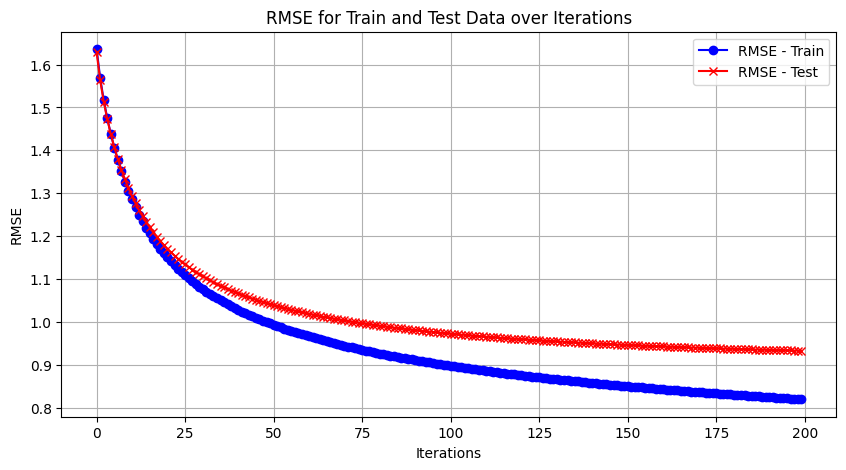

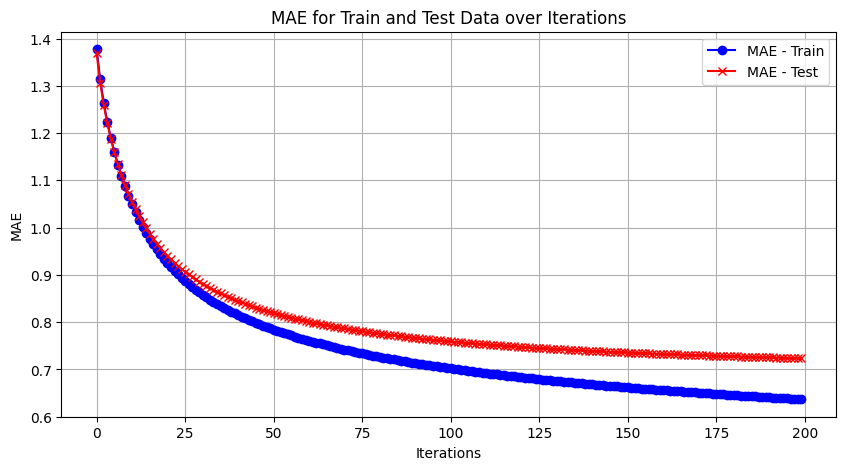

In [16]:
import matplotlib.pyplot as plt

# Tracer le RMSE pour l'entraînement et le test sur le même graphe
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterations), rmse_train_list, label='RMSE - Train', color='b', linestyle='-', marker='o')
plt.plot(range(num_iterations), rmse_test_list, label='RMSE - Test', color='r', linestyle='-', marker='x')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE for Train and Test Data over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Tracer le MAE pour l'entraînement et le test sur le même graphe
plt.figure(figsize=(10, 5))
plt.plot(range(num_iterations), mae_train_list, label='MAE - Train', color='b', linestyle='-', marker='o')
plt.plot(range(num_iterations), mae_test_list, label='MAE - Test', color='r', linestyle='-', marker='x')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('MAE for Train and Test Data over Iterations')
plt.legend()
plt.grid(True)
plt.show()


###Essayer un jeu d'hyper-paramètres pour en trouver la meilleure combinaison

In [18]:
import itertools

# Définir les hyperparamètres à tester
learning_rates = [0.0001, 0.0005]
lambda_regs = [1, 5]
latent_features_list = [10, 20]
num_iterations_list = [100, 200]

# Stocker les résultats
results = []

# Tester toutes les combinaisons possibles d'hyperparamètres
for learning_rate, lambda_reg, latent_features, num_iterations in itertools.product(
        learning_rates, lambda_regs, latent_features_list, num_iterations_list):

    mu_reg = lambda_reg

    print(f"\nTesting Combination: learning_rate={learning_rate}, lambda_reg={lambda_reg}, mu_reg={mu_reg}, latent_features={latent_features}, num_iterations={num_iterations}")

    U, V = gradient_descent(ratings_train, ratings_test, latent_features, learning_rate, lambda_reg, mu_reg, num_iterations)
    predictions = np.dot(U, V.T)

    # Limiter les valeurs prédites dans l'intervalle [0.5, 5]
    clipped_predictions = np.clip(predictions, a_min=0.5, a_max=5)

    # Calculer les métriques pour l'ensemble d'entraînement et de test
    train_rmse, train_mae = RMSE_MAE(ratings_train, clipped_predictions)
    test_rmse, test_mae = RMSE_MAE(ratings_test, clipped_predictions)

    # Stocker les résultats
    results.append({
        "learning_rate": learning_rate,
        "lambda_reg": lambda_reg,
        "mu_reg": mu_reg,
        "latent_features": latent_features,
        "num_iterations": num_iterations,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mae": train_mae,
        "test_mae": test_mae
    })

# Créer un DataFrame pour visualiser les résultats
results_df = pd.DataFrame(results)
best_combination = results_df.loc[results_df['test_rmse'].idxmin()]

print("\nBest Hyperparameter Combination:")
print(best_combination)


Testing Combination: learning_rate=0.0001, lambda_reg=1, mu_reg=1, latent_features=10, num_iterations=100
Iteration 0: Loss = 97551.37837803096

Testing Combination: learning_rate=0.0001, lambda_reg=1, mu_reg=1, latent_features=10, num_iterations=200
Iteration 0: Loss = 94683.77974496488
Iteration 100: Loss = 44717.928157020564

Testing Combination: learning_rate=0.0001, lambda_reg=1, mu_reg=1, latent_features=20, num_iterations=100
Iteration 0: Loss = 135669.71394281136

Testing Combination: learning_rate=0.0001, lambda_reg=1, mu_reg=1, latent_features=20, num_iterations=200
Iteration 0: Loss = 135214.83529179846
Iteration 100: Loss = 59106.10810074475

Testing Combination: learning_rate=0.0001, lambda_reg=5, mu_reg=5, latent_features=10, num_iterations=100
Iteration 0: Loss = 170543.5341184619

Testing Combination: learning_rate=0.0001, lambda_reg=5, mu_reg=5, latent_features=10, num_iterations=200
Iteration 0: Loss = 169677.05345672648
Iteration 100: Loss = 112318.45143424574

Test

###Prédire les ratings spécifiées sur list_ratings_wanted

In [19]:
from scipy.sparse import lil_matrix

# Entraîner le modèle avec la meilleure combinaison trouvée
learning_rate = 0.0005
lambda_reg = 1
mu_reg = 1
latent_features = 10
num_iterations = 100
U, V = gradient_descent(ratings_train, ratings_test, latent_features, learning_rate, lambda_reg, mu_reg, num_iterations)

list_index_wanted = np.load('list_index_wanted.npy')

# Créer une matrice creuse pour stocker les prédictions
num_users, num_items = ratings_train.shape
sparse_matrix = lil_matrix((num_users, num_items))

# Faire des prédictions pour les couples (utilisateur, item) spécifiés dans `list_index_wanted`
for user, item in list_index_wanted:
    if user < num_users and item < num_items:
        # Prédire la note pour le couple (utilisateur, item)
        predicted_rating = np.dot(U[user, :], V[item, :].T)

        # Limiter la valeur prédite dans l'intervalle [0.5, 5]
        predicted_rating = np.clip(predicted_rating, a_min=0.5, a_max=5)

        # Ajouter la prédiction dans la matrice creuse
        sparse_matrix[user, item] = predicted_rating

# Sauvegarder la matrice creuse au format .npy
np.save('SGD_predicted_ratings_matrix.npy', sparse_matrix)

print("Prédictions terminées et matrice creuse sauvegardée avec succès.")

Iteration 0: Loss = 76769.90230277476
Prédictions terminées et matrice creuse sauvegardée avec succès.


#IIIII. la méthode utilisant XGBoost

###Charger les données

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Charger les données d'entraînement et de test
ratings_train = pd.read_excel('ratings_train.xlsx', header=None)
ratings_test = pd.read_excel('ratings_test.xlsx')

# Préparer les données d'entraînement et de test en format de triplets (user, item, rating)
def prepare_triplets(data):
    triplets = []
    num_users, num_items = data.shape
    for user in range(num_users):
        for item in range(num_items):
            rating = data.iloc[user, item]
            if not pd.isna(rating):
                triplets.append((user, item, rating))
    return triplets

train_triplets = prepare_triplets(ratings_train)
test_triplets = prepare_triplets(ratings_test)

# Préparer les caractéristiques pour chaque triplet
def prepare_features(triplets, genres_encoded):
    X = []
    y = []
    for user, item, rating in triplets:
        # Créer les features : ID de l'utilisateur, ID de l'item, et genres encodés
        item_genres = genres_encoded[item] if item < len(genres_encoded) else np.zeros(genres_encoded.shape[1])
        feature_vector = [user, item] + list(item_genres)
        X.append(feature_vector)
        y.append(rating)
    return np.array(X), np.array(y)

# Préparer les caractéristiques d'entraînement et de test
X_train, y_train = prepare_features(train_triplets, genres_encoded)
X_test, y_test = prepare_features(test_triplets, genres_encoded)


###Entrainer le modèle

In [ ]:
# Entraîner XGBoost sur les données d'entraînement
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgboost_model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = xgboost_model.predict(X_test)

# Calculer le RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE sur l'ensemble de test avec XGBoost : {rmse}")

###Prédire les ratings spécifiés dans list_ratings_wanted

In [ ]:
from scipy.sparse import lil_matrix

# Charger la liste des index à prédire
list_index_wanted = np.load('list_index_wanted.npy')

# Créer une matrice creuse pour stocker les prédictions
num_users = ratings_train.shape[0]
num_items = ratings_train.shape[1]
sparse_matrix = lil_matrix((num_users, num_items))

# Prédire les ratings des (user, item) spécifiés dans 'list_index_wanted'
for user, item in list_index_wanted:
    # Créer les features pour le couple (user, item)
    if item < len(genres_encoded):
        item_genres = genres_encoded[item]
    else:
        item_genres = np.zeros(genres_encoded.shape[1])

    feature_vector = [user, item] + list(item_genres)
    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Faire la prédiction
    predicted_rating = xgboost_model.predict(feature_vector)[0]

    # Ajouter la prédiction dans la matrice creuse
    sparse_matrix[user, item] = predicted_rating

# Sauvegarder la matrice creuse au format .npy
np.save('XGB_predicted_ratings_matrix.npy', sparse_matrix)

print("Prédictions terminées et matrice creuse sauvegardée avec succès.")